
Making Brooklyn and Staten Island Outline Maps...
******************* GEOID 36047990100 is in the Brooklyn shapefile but is not in NYU NYC shapefile

Making Brooklyn and Staten Island Outline Maps...
******************* GEOID 36085008900 is in the Staten Island shapefile but is not in NYU NYC shapefile
******************* GEOID 36085990100 is in the Staten Island shapefile but is not in NYU NYC shapefile

Populating new created columns and ploting monthly maps..


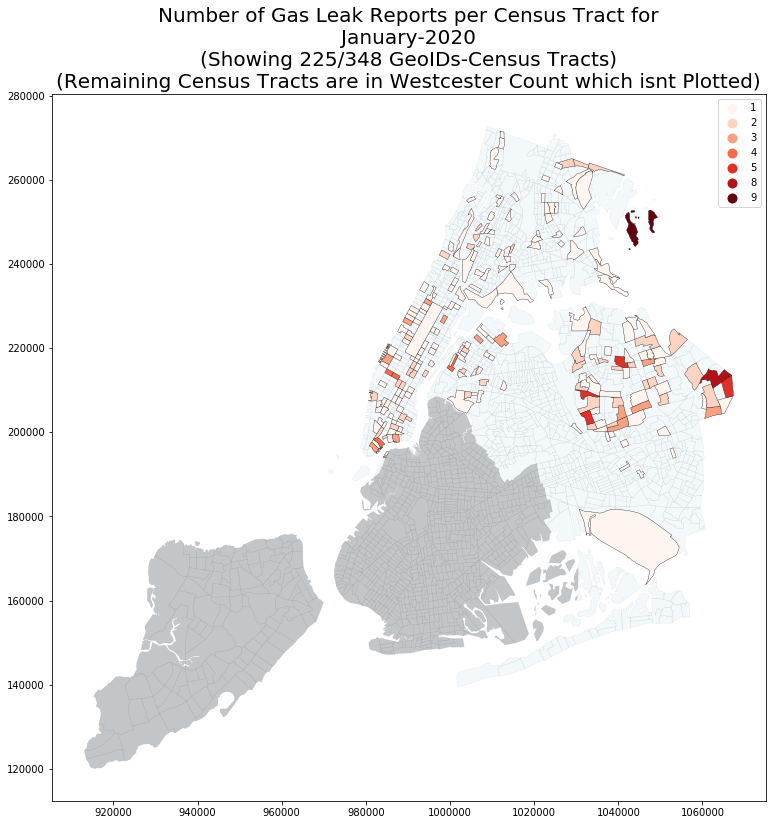

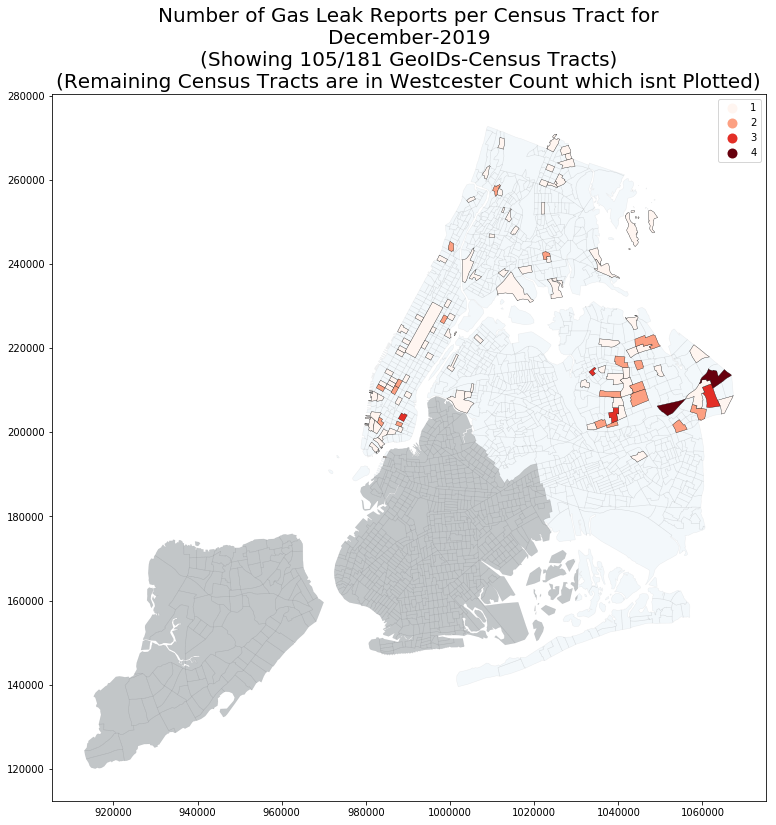

In [2]:
# Part 5.6
# PLOTTING WITH GEOID, WESTCHESTER SHP NOT FOUND YET, NEED TO BLACK OUT BRROKLYN AND STATEN ISLAND
# Plotting the census tracts for all reports that appeared in a specific month                    
# import contextily as ctx
# import matploylib.pyplot as plt
import geopandas as gp
import os
import platform
import pandas as pd
import numpy as np

# A) CREATING DF AND GDF:
shapeFile = "NYU_NYC_34505_SP/nyu_2451_34505.shp"
csvFile = "GasHistory_2010_ReportFrequency_Monthly.csv"
brooklynFile = "TIGER_2010_County_Shapefiles/BrooklynCounty_2010SHP/tl_2010_36047_tract10.shp"
statenFile = "TIGER_2010_County_Shapefiles/StatenIslanCounty_2010SHP"
monthlyDF = pd.read_csv(csvFile)                                                                            # Read the csv file and make a data frame
shapeGDF = gp.read_file(shapeFile)                                                                           # Read the shape file and make a data frame
brooklynGDF = gp.read_file(brooklynFile)
statenGDF = gp.read_file(statenFile)

GDF_GEOID_COL = "tractid"
DF_GEOID_COL  = "GEOID_SCT"
MIN_NUM_TRACTS_NEEDED_TO_PRINT = 150 #max westchester got in a month is 110

# B) ADDING NEW COLS TO SHAPEGDF AND CHANGING DATATYPE OF COLS SO WE CAN COMPARE THEM:
shapeGDF["MonthYear"] = str                                                                               # adding two new cols to shapeGDF
shapeGDF["TotalMonthlyReport" ] = int
shapeGDF["CountyName"] = str 
shapeGDF["CensusBlockID_list"] = str  
shapeGDF["Ticket_list"] = str  
shapeGDF["Classification_list"] = str  
shapeGDF["Zipcode_list"] = str 
shapeGDF["CountyTract"] = str
shapeGDF[[GDF_GEOID_COL]] = shapeGDF[[GDF_GEOID_COL]].apply(pd.to_numeric).astype(int)                                      # Turning GDF_GEOID_COL - the CensusTract number to numpy.int64 values so can query them
shapeGDF[['tractid']] = shapeGDF[['tractid']].apply(pd.to_numeric).astype(int)  
shapeGDF[['tractnum']] = shapeGDF[['tractnum']].apply(pd.to_numeric).astype(int)  
shapeGDF[['name']] = shapeGDF[['name']].apply(pd.to_numeric).astype(int) 
shapeGDF[['bcode']] = shapeGDF[['bcode']].apply(pd.to_numeric).astype(int) 
# print("======================================================================================================== RAW DATA: GDF and monthly DF ========================================================================================================")
# print(shapeGDF)
# print("------------------------------------------------------------------------ monthly DF:------------------------------------------")
# print(monthlyDF)
# print("=============================================================================================================== RAW DATA END =================================================================================================================")

shapeGDF.to_csv("del_monthly.csv")
# C) CON EDISON DOESNT INCLUDE DATA FROM STATEN ISLAND AND BROOKYLN SO GRAY THEM OUT
# BROOKLYN OUTLINE GDF:
print("\nMaking Brooklyn and Staten Island Outline Maps...")
bkGeoidList = list()
for row in range(0, len(brooklynGDF)):
    bkGeoidList.append(int(brooklynGDF.iloc[row]["GEOID10"]))
brooklynOutlineGDF = shapeGDF.copy()
brooklynOutlineGDF.drop(brooklynOutlineGDF.index, inplace=True)  
skipGeoid = []
for geoid in range(0, len(bkGeoidList)):        
    bkGDF = shapeGDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (shapeGDF[GDF_GEOID_COL]  == bkGeoidList[geoid]) 
    ]  
    if len(bkGDF)==0:
        print("******************* GEOID "+str(bkGeoidList[geoid])+" is in the Brooklyn shapefile but is not in NYU NYC shapefile")
    skipGeoid.extend(bkGDF.index.tolist())
    bkGDF = bkGDF.reset_index(drop=True)
    brooklynOutlineGDF = brooklynOutlineGDF.append(bkGDF)
brooklynOutlineGDF.reset_index(drop=True)
# STATEN ISLAND OUTLINE GDF:
print("\nMaking Brooklyn and Staten Island Outline Maps...")
statenGeoidList = list()
for row in range(0, len(statenGDF)):
    statenGeoidList.append(int(statenGDF.iloc[row]["GEOID10"]))
statenOutlineGDF = shapeGDF.copy()
statenOutlineGDF.drop(statenOutlineGDF.index, inplace=True)  
skipGeoid = []
for geoid in range(0, len(statenGeoidList)):        
    statenGDF = shapeGDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (shapeGDF[GDF_GEOID_COL]  == statenGeoidList[geoid]) 
    ]  
    if len(statenGDF)==0:
        print("******************* GEOID "+str(statenGeoidList[geoid])+" is in the Staten Island shapefile but is not in NYU NYC shapefile")
    skipGeoid.extend(statenGDF.index.tolist())
    statenGDF = statenGDF.reset_index(drop=True)
    statenOutlineGDF = statenOutlineGDF.append(statenGDF)
statenOutlineGDF.reset_index(drop=True)



# D) POPULATE THE NEWLY CREATED COLS:
print("\nPopulating new created columns and ploting monthly maps..")
skipMonthIndex = []
count = 0
thisMonthPlotGDF = shapeGDF.copy()
# 0) GO THROUGH EACH ROW OF THE MONTHLY CSV DATA AND PULL OUT ALL ROWS THAT ARE IN THE SAME MONTH -> FROM EACH MINI MONTH SEPERATED DF, SEPERATE FUTHER BY COUNTY NAME -> USE THE GEOID OF EACH COUNTY TO NAME THE GDF FILE
for row in range(0,len(monthlyDF)):
    thisMonthPlotGDF.drop(thisMonthPlotGDF.index, inplace=True)                                      # resetting the month df for this new month
    if row in skipMonthIndex:
        continue

    # 1) SAME MONTH SEPERATION:
    thisMonthsDF = monthlyDF.loc[                                                                               # thisMonthsDF = df that contains all rows for that month-year
        (monthlyDF['MonthYear']  == monthlyDF['MonthYear'][row]) 
    ]  

    if len(thisMonthsDF) <= MIN_NUM_TRACTS_NEEDED_TO_PRINT:                                                                                  # If these r no reports for this month-year so skip
        continue
    skipMonthIndex.extend(thisMonthsDF.index.tolist())
    thisMonthsDF = thisMonthsDF.reset_index(drop=True)
    thisMonthGeoList = thisMonthsDF.GEOID_SCT.tolist()                                                          # need to put census tracts into an array, if i use directly from thisMonthsDF i get errors when there is no 
    thisMonthStr = monthlyDF['MonthYear'][row]

    # 2) SAME COUNTY SEPERATION:
    skipCountyIndex = []
    for row2 in range(0,len(thisMonthsDF)):
        if row2 in skipCountyIndex:
            continue
        thisMonthsCountyDF = thisMonthsDF.loc[                                                                               # thisMonthsCountyDF = df that contains all rows for that month-year
            (thisMonthsDF['CountyName_2010']  == thisMonthsDF['CountyName_2010'][row2]) 
        ]      
        if len(thisMonthsCountyDF) == 0:                                                                                  # If these r no reports for this month-year so skip
            print("----------------- NO BLOCK FOR THIS COUNTY: "+thisMonthsDF['CountyName_2010'][row2])
            continue
        skipCountyIndex.extend(thisMonthsCountyDF.index.tolist())
        thisMonthsCountyDF = thisMonthsCountyDF.reset_index(drop=True)
        thisCountyStr = monthlyDF['CountyName_2010'][row]

        # 3) FROM THE SEPERATED COUNTY MINI DF -> FIND THE GEOID AND POPULATE THE COLS
        skipCountyGeoIdIndex = []
        for row3 in range(0,len(thisMonthsCountyDF)):
            if row3 in skipCountyGeoIdIndex:
                continue
            thisMonthsCountyGeoGDF = shapeGDF.loc[                                                                               # thisMonthsCountyDF = df that contains all rows for that month-year
                (shapeGDF[GDF_GEOID_COL]  == thisMonthsCountyDF[DF_GEOID_COL][row3]) 
            ]      
            if len(thisMonthsCountyGeoGDF) == 0 and thisCountyStr != "Westchester County":                                                                                  # If these r no reports for this month-year so skip
                print("----------------- NO BLOCK FOR THIS COUNTY: ")#+thisMonthsCountyGeoGDF[GDF_GEOID_COL][row3])
                continue
            skipCountyGeoIdIndex.extend(thisMonthsCountyGeoGDF.index.tolist())
            thisMonthsCountyGeoGDF = thisMonthsCountyGeoGDF.reset_index(drop=True)
            # 4) POPULATING THE COLS I ADDED
            #  FROM THE MONTHLY CSV DATA FOR THE SAME GEOIDS
            if len(thisMonthsCountyGeoGDF) != 0:
                thisMonthsCountyGeoGDF.at[0, "MonthYear"] = thisMonthsCountyDF.loc[row3]["MonthYear"]
                thisMonthsCountyGeoGDF.at[0, "TotalMonthlyReport"] = thisMonthsCountyDF.loc[row3]["TotalReports"]
                thisMonthsCountyGeoGDF.at[0, "CountyName"] = thisMonthsCountyDF.loc[row3]["CountyName_2010"]
                thisMonthsCountyGeoGDF.at[0, "CensusBlockID_list"] = thisMonthsCountyDF.loc[row3]["CensusBlockID_list"]
                thisMonthsCountyGeoGDF.at[0, "Ticket_list"] = thisMonthsCountyDF.loc[row3]["Ticket_list"]
                thisMonthsCountyGeoGDF.at[0, "Classification_list"] = thisMonthsCountyDF.loc[row3]["Classification_list"]
                thisMonthsCountyGeoGDF.at[0, "Zipcode_list"] = thisMonthsCountyDF.loc[row3]["Zipcode_list"]
                thisMonthsCountyGeoGDF.at[0, "CountyTract"] = thisMonthsCountyGeoGDF.iloc[0]["CountyName"]+"-"+str(thisMonthsCountyGeoGDF.iloc[0]["namelsad"]).split(" ")[2]   # Add "CountyName-TractNum" to the col
            thisMonthPlotGDF = thisMonthPlotGDF.append(thisMonthsCountyGeoGDF)
        thisMonthPlotGDF = thisMonthPlotGDF.reset_index(drop=True)
    countyTract_list = list()                                                            #
    for i in range(0, len(thisMonthPlotGDF)):
        countyTract_list.append(thisMonthPlotGDF.iloc[i]["CountyTract"])
    thisMonthPlotGDF.to_csv("del_month.csv")

    # 5) PLOT THE MONTH'S DATA:
    figx = 14
    figy = 13
    ax = shapeGDF.plot(alpha=0.05, edgecolor='black', linewidth = 0.6, figsize = (figx,figy))
    ax = brooklynOutlineGDF.plot(alpha=0.2, ax=ax, figsize = (figx,figy), color="black")
    ax = statenOutlineGDF.plot(alpha=0.2, ax=ax, figsize = (figx,figy), color="black")
    map = thisMonthPlotGDF.plot(column='TotalMonthlyReport',cmap = 'Reds', edgecolor='black', linewidth = 0.3, figsize = (figx,figy),legend = True, ax=ax)#, ax=ax, alpha=1) #10,8
    map.set_title(label = 'Number of Gas Leak Reports per Census Tract for\n{0}\n(Showing {2}/{3} GeoIDs-Census Tracts)\n(Remaining Census Tracts are in Westcester County which isnt Plotted)'.format(thisMonthStr, len(countyTract_list), len(thisMonthPlotGDF), len(thisMonthsDF)), fontdict={'fontsize': 20}, loc='center')
